In [ ]:
#가까운 영역에서 원하는 위치나 방향에 대한 전자기파 필드를 측정하고 저장함

To use the `mpa.Near2FarFields` objective, we need to specify the far point(s) of interest; and provide near2far field monitor(s) `mp.Near2FarRegion`, from which the field at far point will be calculated. The monitor(s) has to capture all outgoing fields.

When evaluated, `mpa.Near2FarFields` will return a numpy array with shape (num_of_points, nfreq, 6), where the third axis corresponds to the field components $E_x, E_y, E_z, H_x, H_y, H_z$, in that order. In general, we specify the `mpa.Near2FarFields` objectives functions of the field components at frequencies of interest at points of interest. In this case, we would like to optimize $|E_z|^2$, and focus the fields of different frequency at the same point (0,15,0).

In this example, we try to focus the light at three different frequencies. Our objective is simply the mean of the fields at those frequencies.

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import special, signal

mp.verbosity(0)
Si = mp.Medium(index=3.4)
Air = mp.Medium(index=1.0)

In [2]:
design_region_width = 2
design_region_height = 0.5

pml_size = 1.0

resolution = 30

Sx = 2 * pml_size + design_region_width
Sy = 2 * pml_size + design_region_height + 5
cell_size = mp.Vector3(Sx, Sy)

nf = 3
frequencies = 1 / np.linspace(1.5, 1.6, 3)

minimum_length = 0.09  # minimum length scale (microns)
eta_i = (
    0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

pml_layers = [mp.PML(pml_size)]

fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
source_center = [0, -(design_region_height / 2 + 0.5), 0]
source_size = mp.Vector3(design_region_width, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), Air, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


def mapping(x, eta, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    projected_field = (
        npa.flipud(projected_field) + projected_field
    ) / 2  # left-right symmetry

    # interpolate to actual materials
    return projected_field.flatten()


geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),
    # mp.Block(center=design_region.center, size=design_region.size, material=design_variables, e1=mp.Vector3(x=-1))
    #
    # The commented lines above impose symmetry by overlapping design region with the same design variable. However,
    # currently there is an issue of doing that; instead, we use an alternative approach to impose symmetry.
    # See https://github.com/NanoComp/meep/issues/1984 and https://github.com/NanoComp/meep/issues/2093
]
kpoint = mp.Vector3()
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
)

In [3]:
far_x = [mp.Vector3(0, 2, 0)]
NearRegions = [
    mp.Near2FarRegion(
        center=mp.Vector3(0, design_region_height / 2 + 0.5),
        size=mp.Vector3(design_region_width, 0),
        weight=+1,
    )
]
FarFields = mpa.Near2FarFields(sim, NearRegions, far_x)
ob_list = [FarFields]

#def J1(FF):
#    return npa.mean(npa.abs(FF[0, :, 2]) ** 2)
# 첫번째는 far_x의 index, 두번째는 nfreq, 세번째는 field component 지정

def J0(FF):
    return npa.mean(npa.abs(FF[0, 0, 2]) ** 2)
def J1(FF):
    return npa.mean(npa.abs(FF[0, 1, 2]) ** 2)
def J2(FF):
    return npa.mean(npa.abs(FF[0, 2, 2]) ** 2)

In [4]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J0,J1,J2],
    #objective_functions=[J1]
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    maximum_run_time=2000,
)

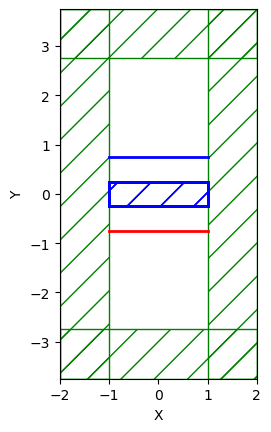

In [5]:
opt.plot2D(True)
plt.show()

In [6]:
evaluation_history = []
cur_iter = [0]


def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])  # compute objective and gradient

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()


In [7]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))


cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 12
ftol = 1e-5

In [8]:
f0, dJ_du = opt([mapping(x, eta_i, cur_beta / beta_scale)], need_gradient=True)

Starting forward run...
Starting adjoint run...


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: divide by zero encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)


Calculating gradient...


In [9]:
dJ_du_0 = np.array_split(np.squeeze(dJ_du), 3)[0]
dJ_du_1 = np.array_split(np.squeeze(dJ_du), 3)[1]
dJ_du_2 = np.array_split(np.squeeze(dJ_du), 3)[2]

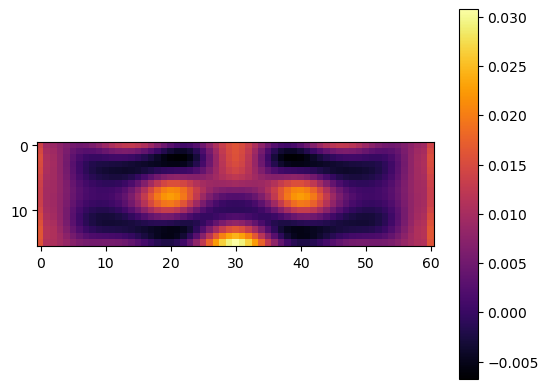

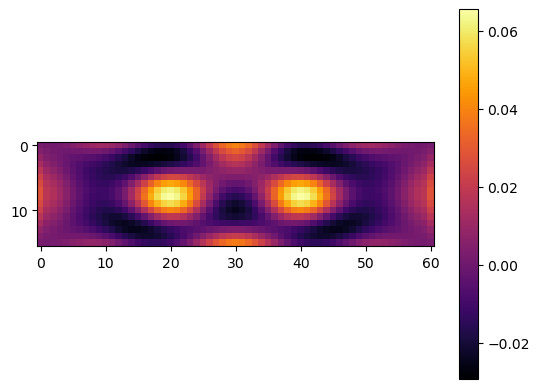

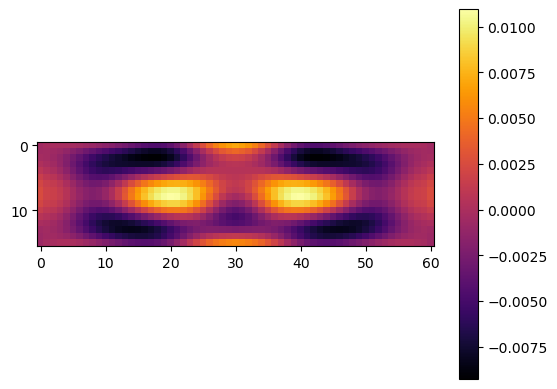

In [10]:
plt.figure()
plt.imshow(np.rot90(dJ_du_0[0,:,0].reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_0[0,:,0]), vmax=np.max(dJ_du_0[0,:,0]))
plt.colorbar()
plt.figure()
plt.imshow(np.rot90(dJ_du_1[0,:,1].reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_1[0,:,1]), vmax=np.max(dJ_du_1[0,:,1]))
plt.colorbar()
plt.figure()
plt.imshow(np.rot90(dJ_du_2[0,:,2].reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_2[0,:,2]), vmax=np.max(dJ_du_2[0,:,2]))
plt.colorbar()
#plt.savefig("adjoint_gradient_map.png")

In [11]:
db = 1e-3
choose = 976
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)
g_discrete_0 = np.squeeze(g_discrete)[:,0]
g_discrete_1 = np.squeeze(g_discrete)[:,1]
g_discrete_2 = np.squeeze(g_discrete)[:,2]

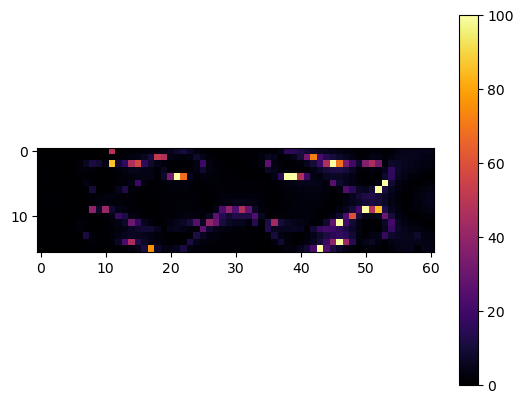

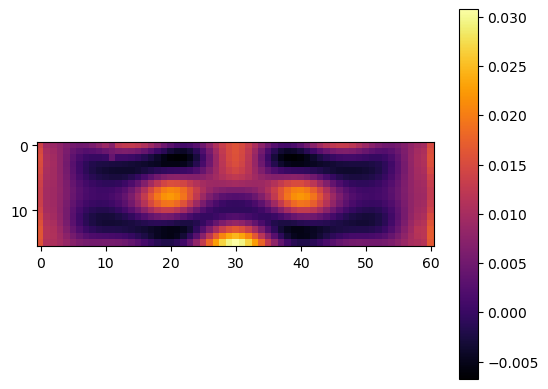

In [12]:
err_0= (np.abs(np.squeeze(g_discrete_0) - np.squeeze(dJ_du_0[0,idx,0]))
    / np.abs(np.squeeze(g_discrete_0))
    * 100)
plt.imshow(np.rot90(err_0.reshape(Nx, Ny)),cmap="inferno", vmin=0, vmax=100)
plt.colorbar()
#plt.savefig("err_res20.png")

plt.figure()
plt.imshow(np.rot90(np.squeeze(g_discrete_0).reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_0[0,:,0]), vmax=np.max(dJ_du_0[0,:,0]))
#plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=-35, vmax=25)
plt.colorbar()
#plt.savefig("FD_gradient_map.png")

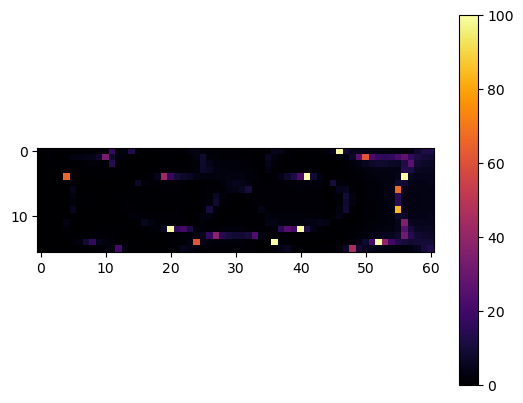

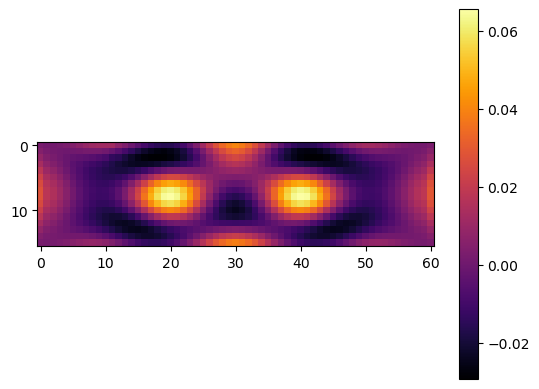

In [13]:
err_1= (np.abs(np.squeeze(g_discrete_1) - np.squeeze(dJ_du_1[0,idx,1]))
    / np.abs(np.squeeze(g_discrete_1))
    * 100)
plt.imshow(np.rot90(err_1.reshape(Nx, Ny)),cmap="inferno", vmin=0, vmax=100)
plt.colorbar()
#plt.savefig("err_res20.png")

plt.figure()
plt.imshow(np.rot90(np.squeeze(g_discrete_1).reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_1[0,:,1]), vmax=np.max(dJ_du_1[0,:,1]))
#plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=-35, vmax=25)
plt.colorbar()
#plt.savefig("FD_gradient_map.png")

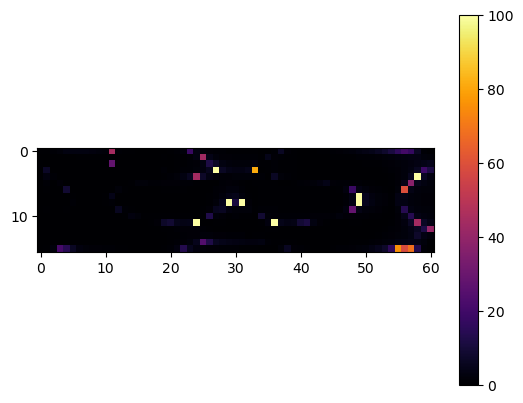

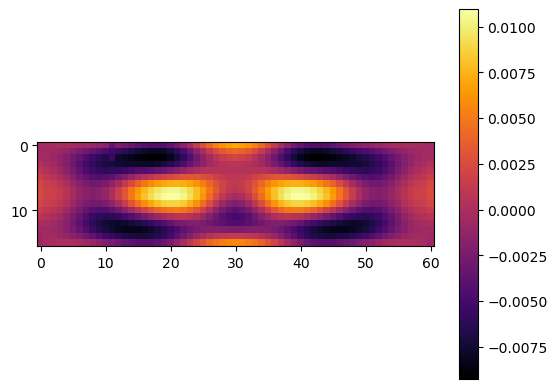

In [14]:
err_2= (np.abs(np.squeeze(g_discrete_2) - np.squeeze(dJ_du_2[0,idx,2]))
    / np.abs(np.squeeze(g_discrete_2))
    * 100)
plt.imshow(np.rot90(err_2.reshape(Nx, Ny)),cmap="inferno", vmin=0, vmax=100)
plt.colorbar()
#plt.savefig("err_res20.png")

plt.figure()
plt.imshow(np.rot90(np.squeeze(g_discrete_2).reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_2[0,:,2]), vmax=np.max(dJ_du_2[0,:,2]))
#plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=-35, vmax=25)
plt.colorbar()
#plt.savefig("FD_gradient_map.png")

In [15]:
(m0, b0) = np.polyfit(g_discrete_0, dJ_du_0[0,idx,0], 1)
(m1, b1) = np.polyfit(g_discrete_1, dJ_du_1[0,idx,1], 1)
(m2, b2) = np.polyfit(g_discrete_2, dJ_du_2[0,idx,2], 1)

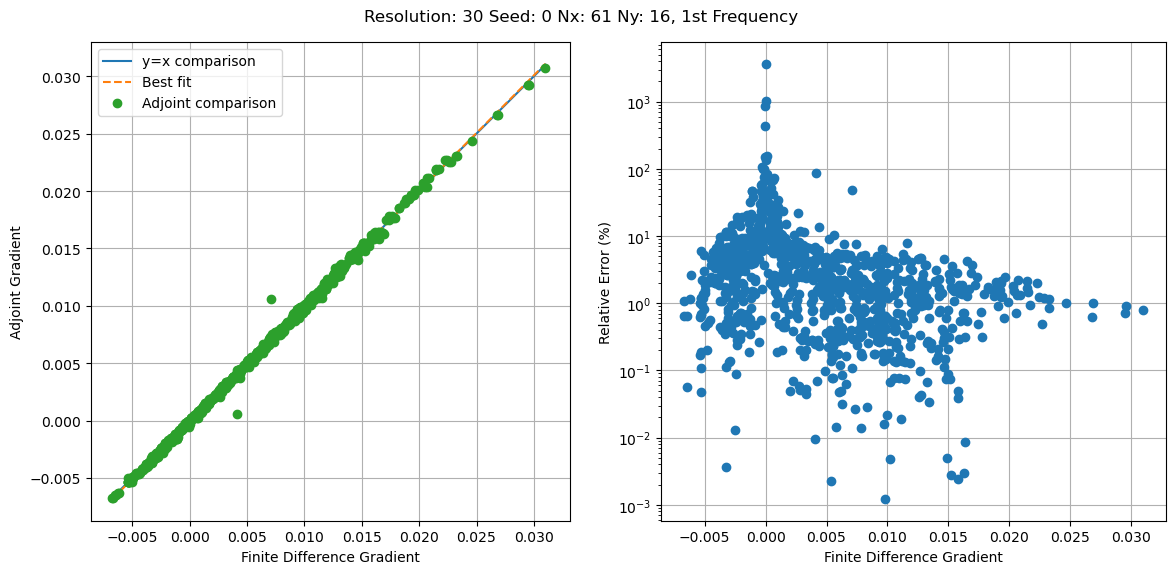

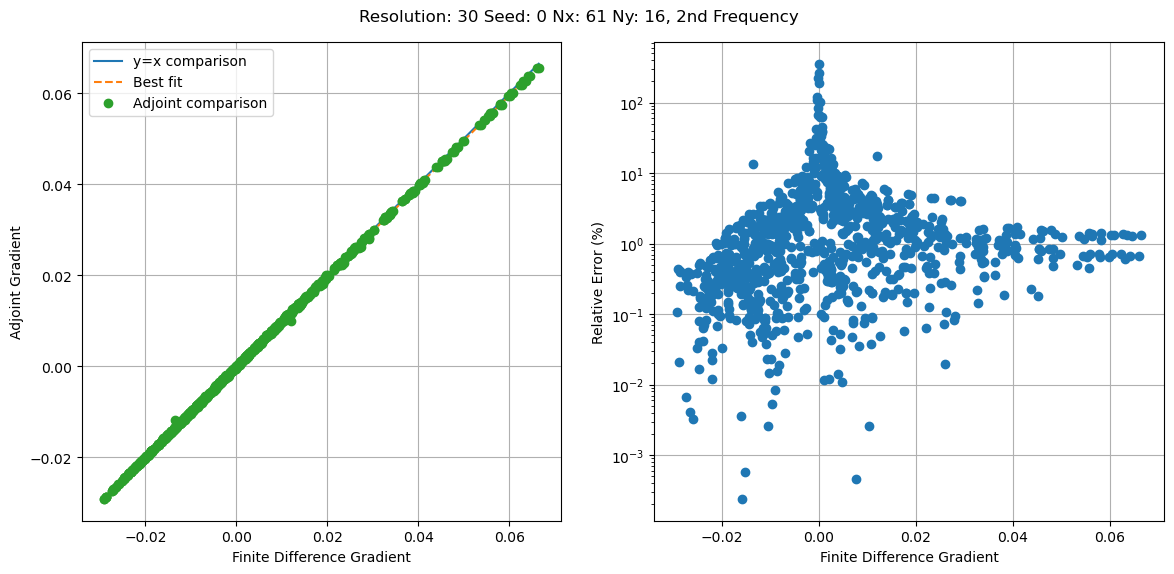

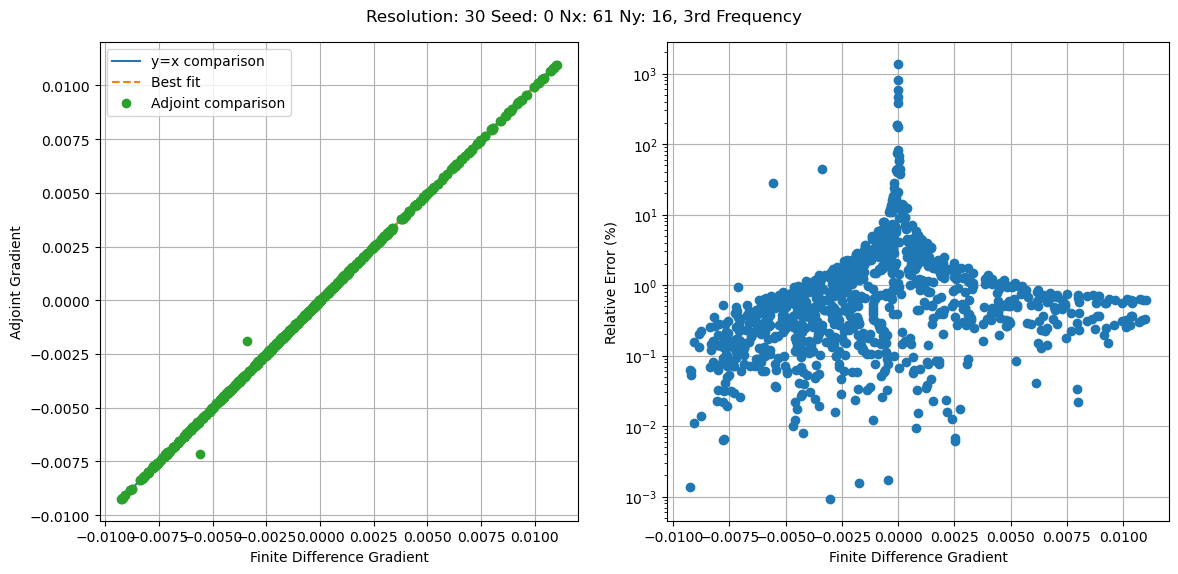

In [16]:
min_g_0 = np.min(g_discrete_0)
max_g_0 = np.max(g_discrete_0)
min_g_1 = np.min(g_discrete_1)
max_g_1 = np.max(g_discrete_1)
min_g_2 = np.min(g_discrete_2)
max_g_2 = np.max(g_discrete_2)
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g_0, max_g_0], [min_g_0, max_g_0], label="y=x comparison")
plt.plot([min_g_0, max_g_0], [m0 * min_g_0 + b0, m0 * max_g_0 + b0], "--", label="Best fit")
plt.plot(g_discrete_0, dJ_du_0[0,idx,0], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err_0 = (
    np.abs(np.squeeze(g_discrete_0) - np.squeeze(dJ_du_0[0,idx,0]))
    / np.abs(np.squeeze(g_discrete_0))
    * 100
)
plt.semilogy(g_discrete_0, rel_err_0, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Nx: {} Ny: {}, 1st Frequency".format(resolution, 0, Nx, Ny))
plt.show()

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g_1, max_g_1], [min_g_1, max_g_1], label="y=x comparison")
plt.plot([min_g_1, max_g_1], [m1 * min_g_1 + b1, m1 * max_g_1 + b1], "--", label="Best fit")
plt.plot(g_discrete_1, dJ_du_1[0,idx,1], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err_1 = (
    np.abs(np.squeeze(g_discrete_1) - np.squeeze(dJ_du_1[0,idx,1]))
    / np.abs(np.squeeze(g_discrete_1))
    * 100
)
plt.semilogy(g_discrete_1, rel_err_1, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Nx: {} Ny: {}, 2nd Frequency".format(resolution, 0, Nx, Ny))
plt.show()

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g_2, max_g_2], [min_g_2, max_g_2], label="y=x comparison")
plt.plot([min_g_2, max_g_2], [m2 * min_g_2 + b2, m2 * max_g_2 + b2], "--", label="Best fit")
plt.plot(g_discrete_2, dJ_du_2[0,idx,2], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err_2 = (
    np.abs(np.squeeze(g_discrete_2) - np.squeeze(dJ_du_2[0,idx,2]))
    / np.abs(np.squeeze(g_discrete_2))
    * 100
)
plt.semilogy(g_discrete_2, rel_err_2, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Nx: {} Ny: {}, 3rd Frequency".format(resolution, 0, Nx, Ny))
plt.show()